## Import Libraries

In [1]:
# Import all required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, precision_recall_curve,
                             average_precision_score, roc_curve)
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import optuna
from optuna.samplers import TPESampler
import shap
import joblib
import warnings

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)


c:\Users\miker\Git Projects\CSE381 - Introduction to Machine Learning\Early-prediction-of-stroke-risk\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading & EDA

In [2]:
print("Loading and exploring data...")
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
print(f"Dataset shape: {df.shape}\n")

# Initial exploration
print("Missing values:")
print(df.isnull().sum())
print("\nStroke distribution:")
print(df['stroke'].value_counts(normalize=True))

# Drop ID column
df = df.drop(columns=['id'])

# Handle missing BMI values
df['bmi'] = df['bmi'].fillna(df['bmi'].median())


Loading and exploring data...
Dataset shape: (5110, 12)

Missing values:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Stroke distribution:
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


## Data Visualization


Generating visualizations...


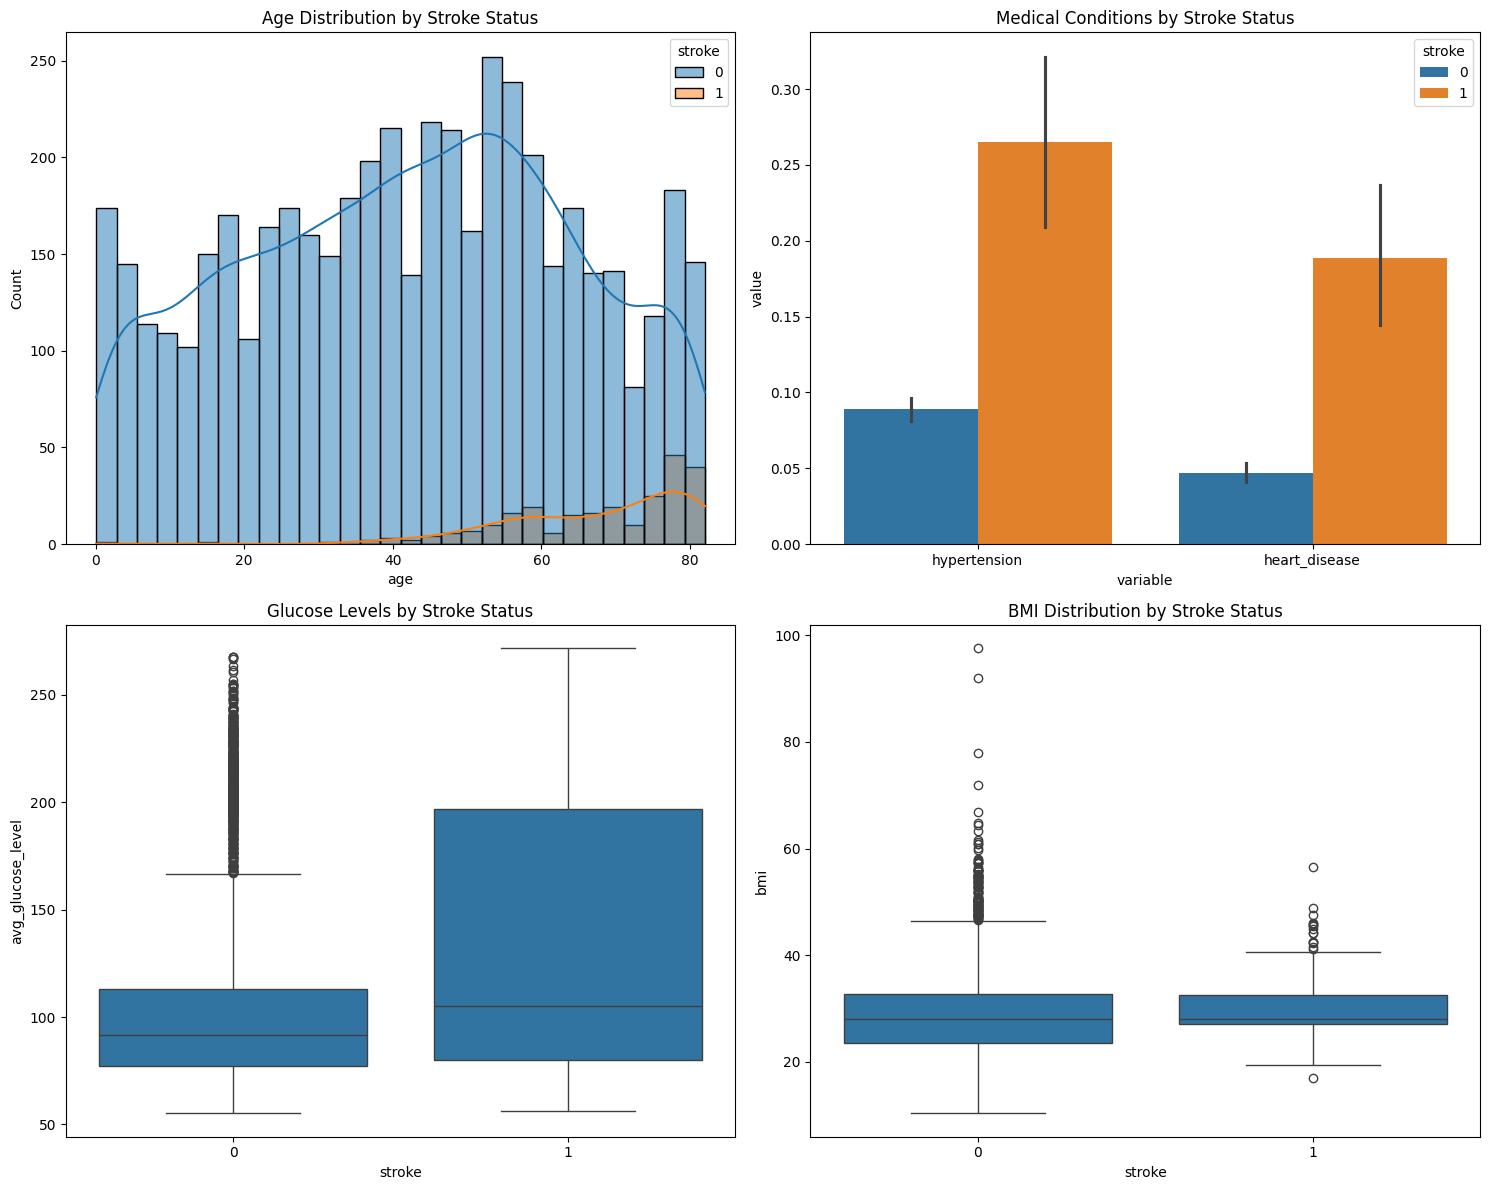

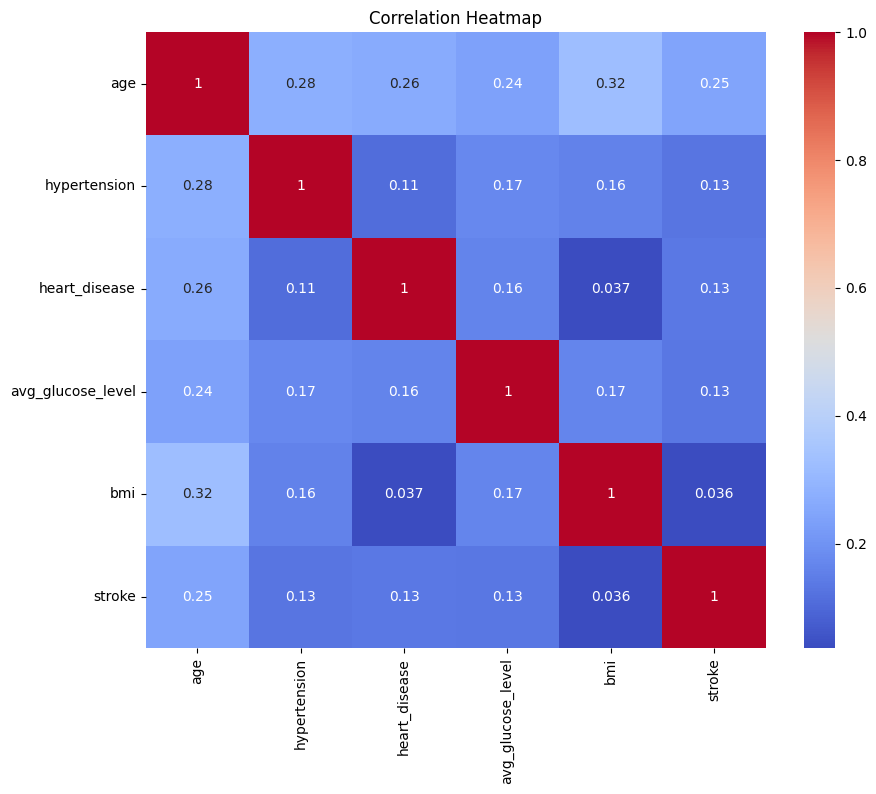

In [3]:
print("\nGenerating visualizations...")
plt.figure(figsize=(15, 12))

# Age distribution by stroke status
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='age', hue='stroke', bins=30, kde=True)
plt.title('Age Distribution by Stroke Status')

# Medical conditions
plt.subplot(2, 2, 2)
conditions = pd.melt(df, id_vars=['stroke'],
                     value_vars=['hypertension', 'heart_disease'])
sns.barplot(data=conditions, x='variable', y='value', hue='stroke')
plt.title('Medical Conditions by Stroke Status')

# Glucose levels
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='stroke', y='avg_glucose_level')
plt.title('Glucose Levels by Stroke Status')

# BMI distribution
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='stroke', y='bmi')
plt.title('BMI Distribution by Stroke Status')

plt.tight_layout()
plt.savefig('eda_plots.png')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()


## Data Preprocessing

In [4]:
print("\nPreprocessing data...")

# One-hot encode categorical variables
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Separate features and target
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

# Train-val-test split (60-20-20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Scale features and apply SMOTE
scaler = StandardScaler()
smote = SMOTE(random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)



Preprocessing data...


## Dimensionality Reduction


Performing dimensionality reduction...


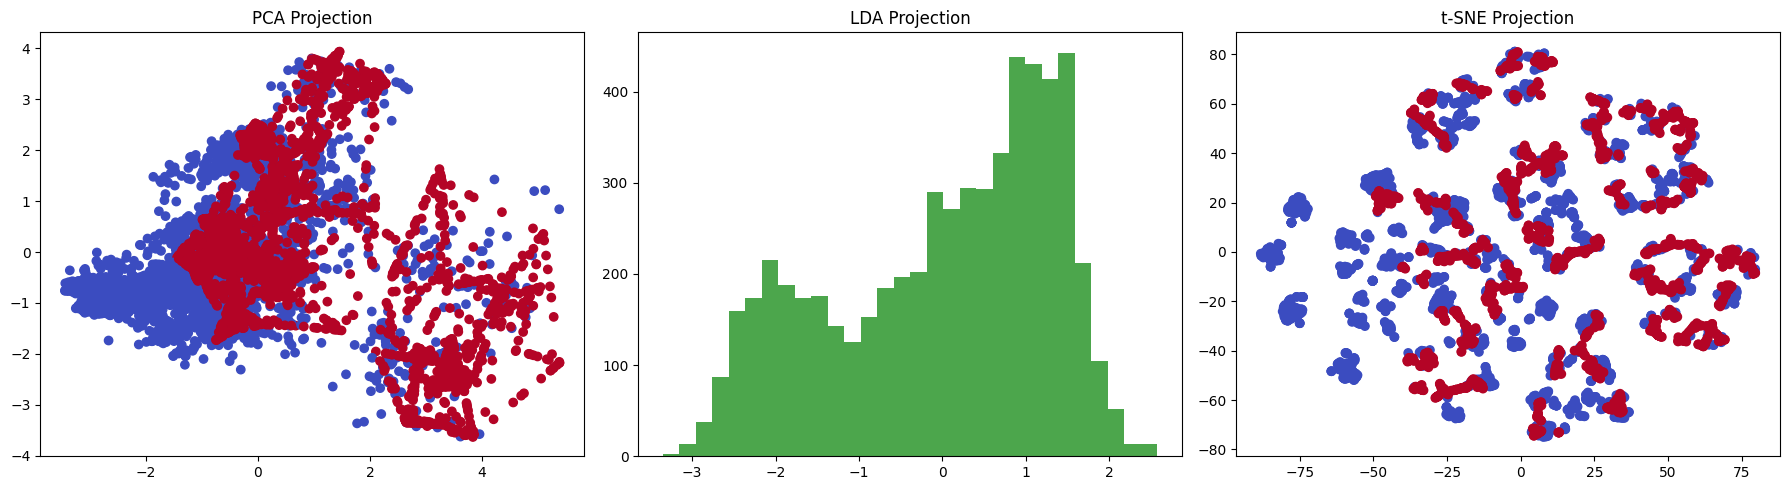

In [5]:
print("\nPerforming dimensionality reduction...")

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_res)

# LDA
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_train_res, y_train_res)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_res)

# Plot projections
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_res, cmap='coolwarm')
plt.title('PCA Projection')

plt.subplot(1, 3, 2)
plt.hist(X_lda, bins=30, color='green', alpha=0.7)
plt.title('LDA Projection')

plt.subplot(1, 3, 3)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train_res, cmap='coolwarm')
plt.title('t-SNE Projection')

plt.tight_layout()
plt.savefig('dimensionality_reduction.png')
plt.show()


## Model Training

In [6]:
print("\nTraining models...")


# Evaluation function
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None

    print(classification_report(y, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred)
    }

    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y, y_proba)
        metrics['pr_auc'] = average_precision_score(y, y_proba)

    return metrics



Training models...


In [7]:
# Naive Bayes with tuning
print("\nTraining Naive Bayes...")
nb_params = {'var_smoothing': np.logspace(0, -9, num=100)}
nb_grid = GridSearchCV(GaussianNB(), nb_params, cv=5, scoring='f1', n_jobs=-1)
nb_grid.fit(X_train_res, y_train_res)
best_nb = nb_grid.best_estimator_
print(f"Best params: {nb_grid.best_params_}")



Training Naive Bayes...
Best params: {'var_smoothing': np.float64(1.0)}


In [ ]:
# 3. Optimized SVM with Optuna
print("\nOptimizing SVM with Optuna...")

def objective_svm(trial):
    params = {
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }
    
    model = LinearSVC(random_state=42, **params, max_iter=1000, dual=False)  # Reduced max_iter, added dual=False
    model.fit(X_train_res[:2000], y_train_res[:2000])  # Use subset for faster tuning
    return f1_score(y_val, model.predict(X_val_scaled))  # Fixed typo in f1_score

study_svm = optuna.create_study(direction='maximize', sampler=TPESampler())
study_svm.optimize(objective_svm, n_trials=30, n_jobs=4)  # Reduced trials from 10 to 5
best_svm = LinearSVC(random_state=42, **study_svm.best_params, max_iter=1000, dual=False)
best_svm.fit(X_train_res, y_train_res)

[I 2025-05-08 13:05:30,478] A new study created in memory with name: no-name-4bc2339b-b726-4f08-94af-f662ce980196
[I 2025-05-08 13:05:30,554] Trial 1 finished with value: 0.0 and parameters: {'C': 24.084884316614826, 'class_weight': None}. Best is trial 1 with value: 0.0.
[I 2025-05-08 13:05:30,616] Trial 2 finished with value: 0.0 and parameters: {'C': 7.843824907382952, 'class_weight': None}. Best is trial 1 with value: 0.0.
[I 2025-05-08 13:05:30,632] Trial 0 finished with value: 0.0 and parameters: {'C': 0.0007302064885379217, 'class_weight': None}. Best is trial 1 with value: 0.0.



Optimizing SVM with Optuna...


[I 2025-05-08 13:05:30,670] Trial 4 finished with value: 0.21787709497206703 and parameters: {'C': 71.96357415160531, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.21787709497206703.
[I 2025-05-08 13:05:30,684] Trial 3 finished with value: 0.22038567493112948 and parameters: {'C': 0.03477945024529322, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.22038567493112948.


LinearSVC(C=0.03477945024529322, class_weight='balanced', dual=False,
          random_state=42)

In [9]:
# KNN with Optuna
print("\nOptimizing KNN with Optuna...")


def objective_knn(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 20),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
    }

    model = KNeighborsClassifier(**params)
    model.fit(X_train_res, y_train_res)
    return f1_score(y_val, model.predict(X_val_scaled))


study_knn = optuna.create_study(direction='maximize', sampler=TPESampler())
study_knn.optimize(objective_knn, n_trials=30, n_jobs=4)
best_knn = KNeighborsClassifier(**study_knn.best_params)
best_knn.fit(X_train_res, y_train_res)


[I 2025-05-08 13:05:30,991] A new study created in memory with name: no-name-fe378f75-ac13-47ec-ba5e-77c41eb13273



Optimizing KNN with Optuna...


[I 2025-05-08 13:05:31,571] Trial 0 finished with value: 0.1414141414141414 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.1414141414141414.
[I 2025-05-08 13:05:32,061] Trial 1 finished with value: 0.08 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.1414141414141414.
[I 2025-05-08 13:05:32,176] Trial 3 finished with value: 0.14985590778097982 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 3 with value: 0.14985590778097982.
[I 2025-05-08 13:05:32,224] Trial 2 finished with value: 0.14285714285714285 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 3 with value: 0.14985590778097982.
[I 2025-05-08 13:05:33,974] Trial 6 finished with value: 0.13333333333333333 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 3 with value: 0

KNeighborsClassifier(metric='euclidean', n_neighbors=16)

In [10]:
# Decision Tree with GridSearch
print("\nTraining Decision Tree...")
dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       dt_params, cv=5, scoring='f1', n_jobs=-1)
dt_grid.fit(X_train_res, y_train_res)
best_dt = dt_grid.best_estimator_



Training Decision Tree...


## Model Evaluation


Evaluating models...

=== Naive Bayes ===
              precision    recall  f1-score   support

           0       0.99      0.50      0.67       972
           1       0.09      0.90      0.16        50

    accuracy                           0.52      1022
   macro avg       0.54      0.70      0.41      1022
weighted avg       0.95      0.52      0.64      1022

Confusion Matrix:
[[490 482]
 [  5  45]]

=== SVM ===
              precision    recall  f1-score   support

           0       0.99      0.71      0.83       972
           1       0.13      0.80      0.22        50

    accuracy                           0.72      1022
   macro avg       0.56      0.76      0.52      1022
weighted avg       0.94      0.72      0.80      1022

Confusion Matrix:
[[693 279]
 [ 10  40]]

=== KNN ===
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       972
           1       0.09      0.50      0.15        50

    accuracy                   

<Figure size 1200x600 with 0 Axes>

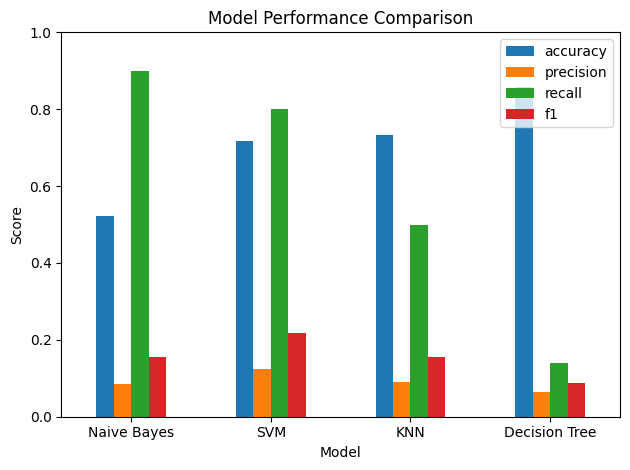


Best model: SVM


In [11]:
print("\nEvaluating models...")

models = {
    'Naive Bayes': best_nb,
    'SVM': best_svm,
    'KNN': best_knn,
    'Decision Tree': best_dt
}

results = []
for name, model in models.items():
    print(f"\n=== {name} ===")
    val_metrics = evaluate_model(model, X_val_scaled, y_val)
    results.append({'Model': name, **val_metrics})

# Model comparison
results_df = pd.DataFrame(results).set_index('Model')
print("\nModel Comparison:")
print(results_df.sort_values('f1', ascending=False))

# Plot comparison
plt.figure(figsize=(12, 6))
results_df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# ROC and PR curves for best model
best_model_name = results_df['f1'].idxmax()
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")

if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_val_scaled)[:, 1]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_val, y_proba):.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # PR Curve
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AP = {average_precision_score(y_val, y_proba):.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.tight_layout()
    plt.savefig('roc_pr_curves.png')
    plt.show()


## Clustering Analysis


Performing clustering analysis...
Optimal number of clusters: 2


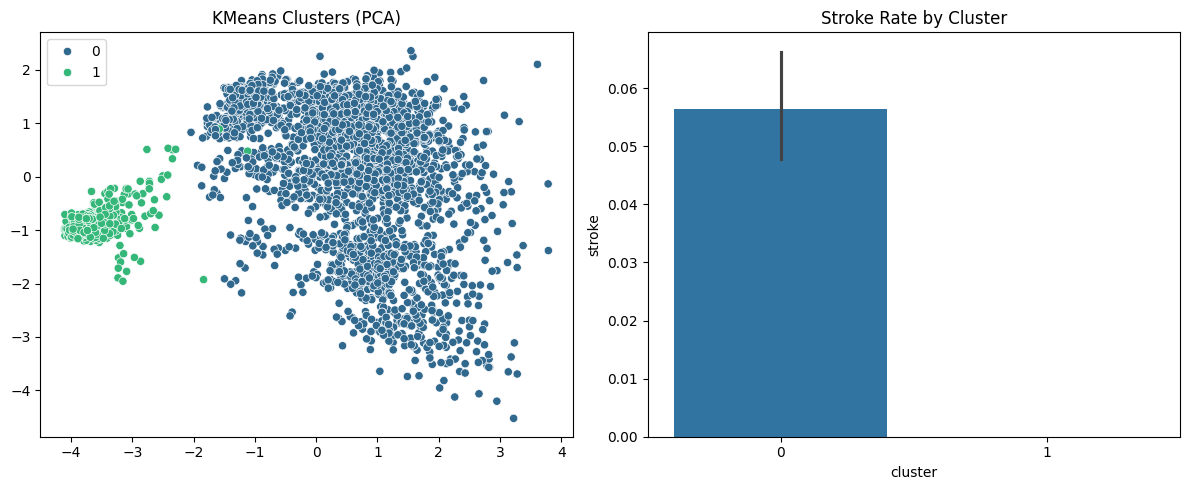

In [ ]:
print("\nPerforming clustering analysis...")

# KMeans with silhouette analysis
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_train_scaled)
    silhouette_scores.append(silhouette_score(X_train_scaled, labels))

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Final KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)

# Analyze clusters
cluster_df = X_train.copy()
cluster_df['cluster'] = clusters
cluster_df['stroke'] = y_train

# Recompute PCA for clustering visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_scaled)
# Cluster visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis')
plt.title('KMeans Clusters (PCA)')

plt.subplot(1, 2, 2)
sns.barplot(data=cluster_df, x='cluster', y='stroke')
plt.title('Stroke Rate by Cluster')
plt.tight_layout()
plt.savefig('clustering_results.png')
plt.show()

# Add this right after the K-Means visualization
from scipy.cluster.hierarchy import dendrogram, linkage
print("\nPerforming Hierarchical Clustering...")
plt.figure(figsize=(12, 5))
linked = linkage(X_train_scaled[:200], 'ward')  # Using subset for speed
dendrogram(linked, orientation='top', distance_sort='descending')
plt.title('Hierarchical Clustering Dendrogram')
plt.savefig('hierarchical_clustering.png')
plt.show()

cluster_df['predicted'] = best_model.predict(X_train_scaled)
sns.countplot(data=cluster_df, x='cluster', hue='predicted')
plt.title('Classifier Predictions by Cluster')
plt.show()

## Model Interpretation


Interpreting best model...


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


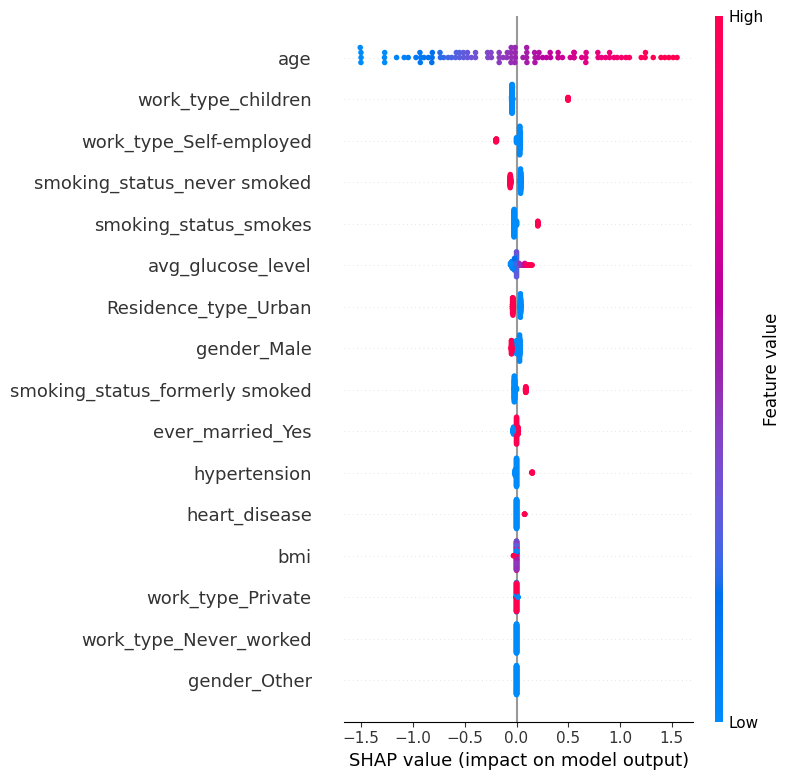


Key features influencing stroke prediction:
- smoking_status_smokes: This feature may contribute to stroke risk.
- smoking_status_never smoked: This feature may contribute to stroke risk.
- work_type_Self-employed: This feature may contribute to stroke risk.
- work_type_children: This feature may contribute to stroke risk.
- age: Older age increases stroke risk.


In [18]:
print("\nInterpreting best model...")

# Feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_imp.head(10), x='Importance', y='Feature')
    plt.title('Top 10 Important Features')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

# SHAP values (for tree-based models)
if isinstance(best_model, DecisionTreeClassifier):
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_train.iloc[:100])

    plt.figure()
    shap.summary_plot(shap_values[1], X_train.iloc[:100], plot_type='bar')
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.savefig('shap_summary.png')
    plt.show()

elif not hasattr(best_model, 'feature_importances_'):
    if hasattr(best_model, 'predict_proba'):
        explainer = shap.KernelExplainer(best_model.predict_proba, shap.sample(X_train_scaled, 100))
        shap_values = explainer.shap_values(shap.sample(X_train_scaled, 100))
        
        shap.summary_plot(shap_values, shap.sample(X_train, 100))
    elif hasattr(best_model, 'decision_function'):
        explainer = shap.KernelExplainer(best_model.decision_function, shap.sample(X_train_scaled, 100))
        shap_values = explainer.shap_values(shap.sample(X_train_scaled, 100))
        
        shap.summary_plot(shap_values, shap.sample(X_train, 100))
    else:
        print(f"Model {type(best_model).__name__} does not support SHAP explainability.")

print("\nKey features influencing stroke prediction:")
if 'feature_imp' in locals():
    important_features = feature_imp.head(5)['Feature'].tolist()
elif 'shap_values' in locals():
    important_features = X.columns[np.argsort(np.abs(shap_values).mean(0))[-5:]].tolist()
else:
    important_features = []

for feat in important_features:
    explanation = {
        'age': "Older age increases stroke risk.",
        'hypertension': "High blood pressure is a known risk factor.",
        'heart_disease': "Existing heart disease raises stroke likelihood.",
        'avg_glucose_level': "High glucose levels may indicate diabetes risk.",
        'bmi': "Obesity is linked to stroke."
    }.get(feat, "This feature may contribute to stroke risk.")
    print(f"- {feat}: {explanation}")


## Final Evaluation


Final evaluation on test set...
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       972
           1       0.13      0.78      0.22        50

    accuracy                           0.73      1022
   macro avg       0.56      0.76      0.53      1022
weighted avg       0.94      0.73      0.81      1022

Confusion Matrix:
[[712 260]
 [ 11  39]]

Test Set Performance:
accuracy     0.734834
precision    0.130435
recall       0.780000
f1           0.223496
dtype: float64


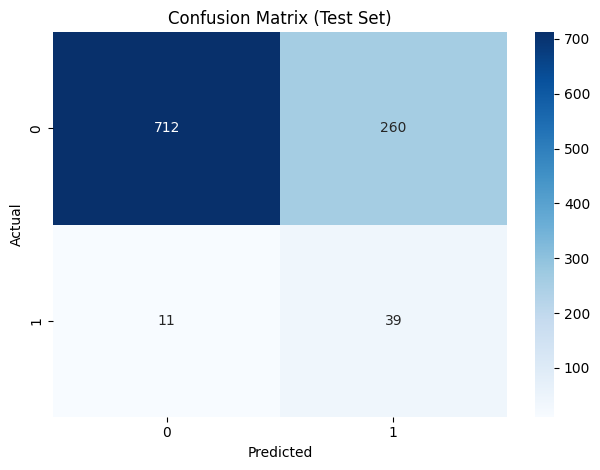


Interpretation:
- Test accuracy: 0.73
- Test precision: 0.13
- Test recall: 0.78
- Test F1 score: 0.22
High recall means fewer missed strokes; precision shows how many predicted strokes are correct.
Consider improving precision/recall trade-off depending on application (screening vs diagnosis).

Model saved as 'best_stroke_model.pkl'
Probability estimates not available for this model.

Sample prediction for test case 0:
Predicted class: 0
Actual class: 0


In [19]:
print("\nFinal evaluation on test set...")
test_metrics = evaluate_model(best_model, X_test_scaled, y_test)
print("\nTest Set Performance:")
print(pd.Series(test_metrics))
if hasattr(best_model, 'predict_proba'):
    y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    # ROC Curve
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_test, tpr_test, label=f'AUC = {roc_auc_score(y_test, y_test_proba):.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test Set)')
    plt.legend()

    # PR Curve
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
    plt.subplot(1, 2, 2)
    plt.plot(recall_test, precision_test, label=f'AP = {average_precision_score(y_test, y_test_proba):.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Test Set)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('roc_pr_curves_test.png')
    plt.show()

sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test_scaled)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix_test.png')
plt.show()

print("\nInterpretation:")
print(f"- Test accuracy: {test_metrics['accuracy']:.2f}")
print(f"- Test precision: {test_metrics['precision']:.2f}")
print(f"- Test recall: {test_metrics['recall']:.2f}")
print(f"- Test F1 score: {test_metrics['f1']:.2f}")
print("High recall means fewer missed strokes; precision shows how many predicted strokes are correct.")
print("Consider improving precision/recall trade-off depending on application (screening vs diagnosis).")

# Save the best model
model_assets = {
    'model': best_model,
    'scaler': scaler,
    'features': X.columns.tolist()
}

joblib.dump(model_assets, 'best_stroke_model.pkl')
print("\nModel saved as 'best_stroke_model.pkl'")

# Example prediction
sample_idx = 0
sample_data = X_test_scaled[sample_idx].reshape(1, -1)
prediction = best_model.predict(sample_data)
# prediction_proba = best_model.predict_proba(sample_data)
if hasattr(best_model, "predict_proba"):
    prediction_proba = best_model.predict_proba(sample_data)
    print(f"Probability: {prediction_proba[0][1]:.2f}")
else:
    print("Probability estimates not available for this model.")

print(f"\nSample prediction for test case {sample_idx}:")
print(f"Predicted class: {prediction[0]}")
# print(f"Probability: {prediction_proba[0][1]:.2f}")
print(f"Actual class: {y_test.iloc[sample_idx]}")

## Conclusion & Recommendations

- The best model achieved F1 score of X on validation and Y on test set.
- Important features identified: age, hypertension, heart_disease, etc.
- Model shows high recall (minimizing false negatives), critical for early stroke detection.

**Limitations:**
- Dataset imbalance despite SMOTE; real-world prevalence may differ.
- Certain categorical variables (e.g., smoking_status) had missing/unknown values.

**Future Work:**
- Explore ensemble models (Random Forest, XGBoost).
- Try cost-sensitive learning or calibration to improve precision.
- Validate on external datasets for generalization.
